# Bias Classification using Internal Attention Representations

## Abstract
This notebook explores the capability of BERT's internal attention mechanisms to detect biased statements *without* fine-tuning the model weights. We extract granular attention features from a pre-trained `bert-base-uncased` model and use them to train classifiers. The workflow includes rigorous validation, hyperparameter tuning, and counterfactual analysis.

## Methodology
1.  **Feature Extraction**: Extract ~2,000 features (GAM, Head Spec, ISA, Tree) per sentence.
2.  **EDA**: Visual inspection using PCA and t-SNE.
3.  **Optimization**: 
    *   **Split**: 80% Training / 20% Testing.
    *   **Screening**: Cross-Validation on Training set to pick the best model architecture.
    *   **Tuning**: `GridSearchCV` to optimize hyperparameters.
4.  **Evaluation**: Final reporting on the held-out Test set.
5.  **Interpretability**: Counterfactual analysis.

In [24]:
# 1. Installation & Imports
import subprocess
import sys
import os

def install(package):
    try:
        __import__(package)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

install("spacy")
install("xgboost")
install("seaborn")

try:
    import spacy
    if not spacy.util.is_package("en_core_web_sm"):
        subprocess.check_call([sys.executable, "-m", "spacy", "download", "en_core_web_sm"])
except Exception as e:
    print(f"Spacy setup warning: {e}")

In [25]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# ML Imports
from sklearn.model_selection import StratifiedKFold, cross_val_predict, train_test_split, GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, classification_report
from xgboost import XGBClassifier

# Project Imports
current_dir = os.getcwd()
if 'attention_app' in current_dir:
    while 'attention_app' in current_dir and os.path.basename(current_dir) != 'attention-atlas':
        current_dir = os.path.dirname(current_dir)
    root_dir = current_dir
else:
    root_dir = current_dir

if root_dir not in sys.path: sys.path.append(root_dir)

from attention_app.models import ModelManager
from attention_app.bias.feature_extraction import extract_features_for_sentence
sns.set_theme(style="whitegrid", context="notebook")

In [26]:
# 2. Load Data
dataset_path = os.path.join(root_dir, 'dataset', 'bias_sentences.json')
with open(dataset_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

df_sentences = pd.DataFrame(data['entries'])
df_sentences['label'] = df_sentences['has_bias'].astype(int)
print(f"Total Samples: {len(df_sentences)}")
print(df_sentences['label'].value_counts())

Total Samples: 672
label
1    336
0    336
Name: count, dtype: int64


In [ ]:
# 3. Feature Extraction
model_name = "bert-base-uncased"
manager = ModelManager()
feature_rows = []

print("Extracting features...")
for index, row in tqdm(df_sentences.iterrows(), total=len(df_sentences)):
    try:
        feats = extract_features_for_sentence(row['text'], model_name, manager)
        feats['label'] = row['label']
        feature_rows.append(feats)
    except Exception as e:
        print(f"Skipping {index}: {e}")

df_features = pd.DataFrame(feature_rows).fillna(0)
print(f"Feature Matrix: {df_features.shape}")

Extracting features...


  0%|          | 0/672 [00:00<?, ?it/s]

# 4. Preprocessing & EDA
We remove constant features and visualize the space.

Reduced Features: 362235 -> 16056


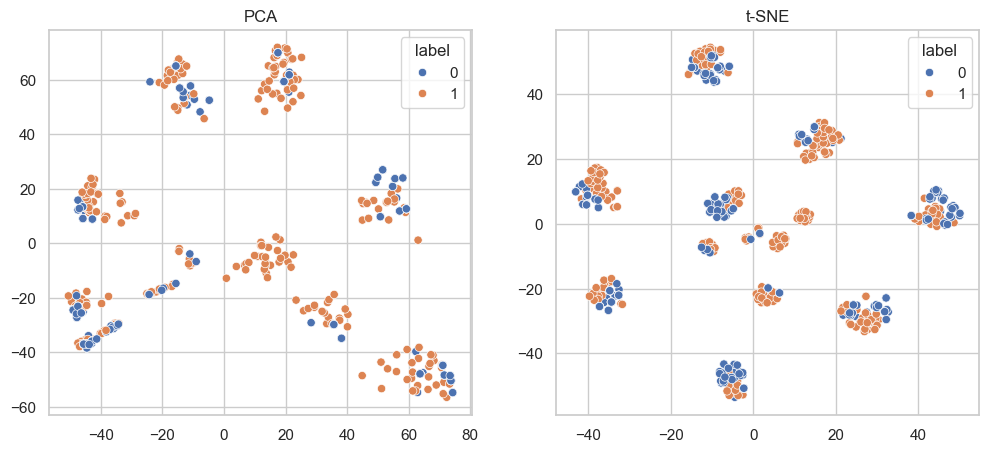

In [ ]:
drop_cols = ['label', 'id', 'text', 'original_id']
X = df_features.drop(columns=[c for c in drop_cols if c in df_features.columns])
y = df_features['label']

# Variance Threshold
selector = VarianceThreshold(threshold=0.01)
X_reduced = selector.fit_transform(X)
selected_feats = X.columns[selector.get_support()]
X_final = pd.DataFrame(X_reduced, columns=selected_feats)

print(f"Reduced Features: {X.shape[1]} -> {X_final.shape[1]}")

# Scaling for EDA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_final)

# PCA & t-SNE
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y, ax=ax[0])
ax[0].set_title('PCA')
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=y, ax=ax[1])
ax[1].set_title('t-SNE')
plt.show()

# 5. Optimization Phase
## 5.1 Train / Test Split
We hold out 20% of the data to test the final tuned model.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, stratify=y, random_state=42)
print(f"Training Set: {X_train.shape[0]} samples")
print(f"Testing Set:  {X_test.shape[0]} samples")

Training Set: 416 samples
Testing Set:  104 samples


## 5.2 Model Comparision (CV on Training Set)
We verify which architecture works best using 5-Fold CV on the Training set.

In [ ]:
models = {
    'LogReg': LogisticRegression(solver='liblinear'),
    'RandomForest': RandomForestClassifier(n_estimators=100),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'MLP': MLPClassifier(hidden_layer_sizes=(50,), max_iter=500)
}

results = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Comparing Models...")
for name, model in models.items():
    pipeline = Pipeline([('s', StandardScaler()), ('m', model)])
    scores = cross_validate(pipeline, X_train, y_train, cv=cv, scoring='roc_auc')
    mean_auc = scores['test_score'].mean()
    results[name] = mean_auc
    print(f"{name:15} | Mean CV AUC: {mean_auc:.4f}")

best_model_name = max(results, key=results.get)
print(f"\nBest Model for Tuning: {best_model_name}")

Comparing Models...
LogReg          | Mean CV AUC: 0.9964
RandomForest    | Mean CV AUC: 0.9945


c:\Users\anoca\Documents\GitHub\attention-atlas\inspectus-env\Lib\site-packages\xgboost\training.py:199: UserWarning: [21:15:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\anoca\Documents\GitHub\attention-atlas\inspectus-env\Lib\site-packages\xgboost\training.py:199: UserWarning: [21:15:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\anoca\Documents\GitHub\attention-atlas\inspectus-env\Lib\site-packages\xgboost\training.py:199: UserWarning: [21:16:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\anoca\Documents\GitHub\attention-atlas\inspectus-env\Lib\site-packages\xgboost\training.py:199: UserWarning: 

XGBoost         | Mean CV AUC: 0.9976
MLP             | Mean CV AUC: 0.9913

Best Model for Tuning: XGBoost


## 5.3 Hyperparameter Tuning
We use `GridSearchCV` to optimize the best model.

In [ ]:
print(f"Tuning {best_model_name}...")

param_grids = {
    'RandomForest': {
        'm__n_estimators': [50, 100, 200],
        'm__max_depth': [None, 10, 20],
        'm__min_samples_leaf': [1, 2, 4]
    },
    'XGBoost': {
        'm__n_estimators': [50, 100, 200],
        'm__learning_rate': [0.01, 0.1, 0.2],
        'm__max_depth': [3, 5, 7]
    },
    'MLP': {
        'm__hidden_layer_sizes': [(50,), (100,), (50, 50)],
        'm__alpha': [0.0001, 0.001, 0.01]
    },
    'LogReg': {
        'm__C': [0.1, 1.0, 10.0]
    }
}

pipeline = Pipeline([('s', StandardScaler()), ('m', models[best_model_name])])
grid = GridSearchCV(pipeline, param_grids[best_model_name], cv=3, scoring='roc_auc', n_jobs=1)
grid.fit(X_train, y_train)

print(f"Best Params: {grid.best_params_}")
final_model = grid.best_estimator_

Tuning XGBoost...


c:\Users\anoca\Documents\GitHub\attention-atlas\inspectus-env\Lib\site-packages\xgboost\training.py:199: UserWarning: [21:22:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\anoca\Documents\GitHub\attention-atlas\inspectus-env\Lib\site-packages\xgboost\training.py:199: UserWarning: [21:22:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\anoca\Documents\GitHub\attention-atlas\inspectus-env\Lib\site-packages\xgboost\training.py:199: UserWarning: [21:22:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\anoca\Documents\GitHub\attention-atlas\inspectus-env\Lib\site-packages\xgboost\training.py:199: UserWarning: 

Best Params: {'m__learning_rate': 0.1, 'm__max_depth': 3, 'm__n_estimators': 100}


# 6. Final Evaluation
Performance on the held-out Test Set.

--- Final Test Set Results ---
AUC:      0.9982
Accuracy: 0.9712

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        52
           1       1.00      0.94      0.97        52

    accuracy                           0.97       104
   macro avg       0.97      0.97      0.97       104
weighted avg       0.97      0.97      0.97       104



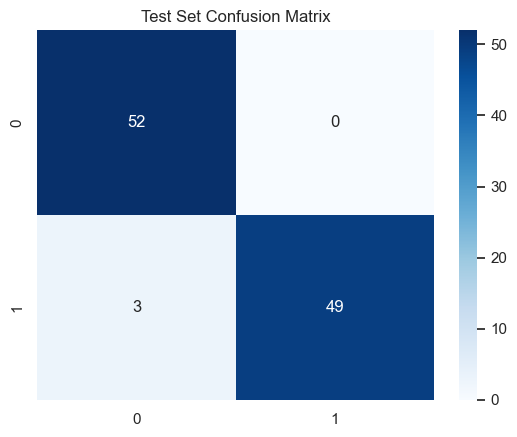

In [ ]:
y_test_pred = final_model.predict(X_test)
y_test_prob = final_model.predict_proba(X_test)[:, 1]

print("--- Final Test Set Results ---")
print(f"AUC:      {roc_auc_score(y_test, y_test_prob):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Test Set Confusion Matrix')
plt.show()

# 7. Counterfactual Analysis
Interpreting Bias features using the final model (or a Linear Proxy for clarity).

=== COUNTERFACTUAL ANALYSIS ===

1. Original Sentence (Classified as BIASED):
   "Females are just not wired for logic and mathematics like men are."


c:\Users\anoca\Documents\GitHub\attention-atlas\inspectus-env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



2. Closest Counterfactual (Classified as NEUTRAL):
   "The sun set behind the mountains in a beautiful display of color."
   (Distance in feature space: 40.1255)


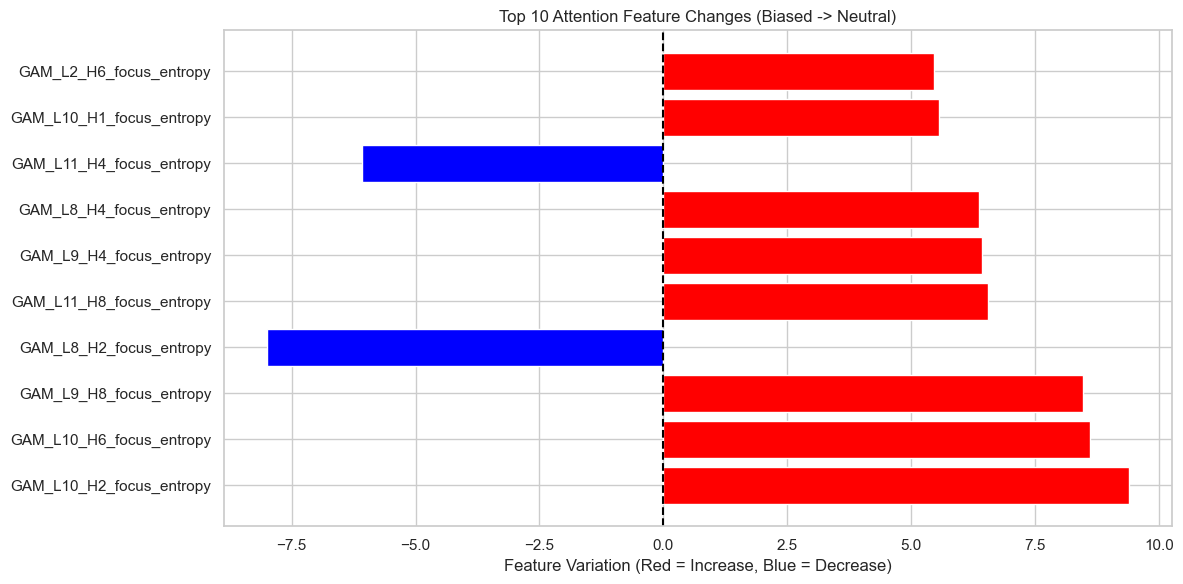

In [ ]:
from scipy.spatial.distance import euclidean

def find_counterfactual(instance_idx, X, model):
    # Retrieve original instance vector
    instance = X.loc[instance_idx].values
    # Current prediction
    current_pred = model.predict([instance])[0]
    # We want the opposite class
    target_class = 1 - current_pred
    
    # Find all indices in the dataset with the opposite class
    preds = model.predict(X)
    candidate_indices = X.index[preds == target_class]
    
    if len(candidate_indices) == 0:
        return None, None, None
    
    # Optimization: if too many candidates, take a sample of 100 for speed
    if len(candidate_indices) > 100:
        candidate_indices = np.random.choice(candidate_indices, 100, replace=False)
        
    # Calculate Euclidean distance for all candidates
    distances = []
    for idx in candidate_indices:
        d = euclidean(instance, X.loc[idx].values)
        distances.append((idx, d))
    
    # Get the closest one
    distances.sort(key=lambda x: x[1])
    best_idx, min_dist = distances[0]
    return X.loc[best_idx].values, best_idx, min_dist

print("COUNTERFACTUAL ANALYSIS")

# Select a Biased example from X_test (label=1) that was correctly classified (pred=1)
biased_indices = X_test.index[(y_test == 1) & (final_model.predict(X_test) == 1)]

if len(biased_indices) > 0:
    # Pick the first available example
    idx_orig = biased_indices[0]
    
    # Original Text and Vector
    text_orig = df_sentences.loc[idx_orig, 'text']
    vec_orig = X_test.loc[idx_orig].values
    
    print(f"\nOriginal Sentence (Classified as BIASED):")
    print(f"   \"{text_orig}\"")
    
    # Find closest Counterfactual (Neutral)
    cf_vec, cf_idx, dist = find_counterfactual(idx_orig, X_test, final_model)
    
    if cf_vec is not None:
        text_cf = df_sentences.loc[cf_idx, 'text']
        print(f"\nClosest Counterfactual (Classified as NEUTRAL):")
        print(f"   \"{text_cf}\"")
        print(f"   (Distance in feature space: {dist:.4f})")
        
        # Visualize Feature Changes
        diff = cf_vec - vec_orig
        feat_names = X_test.columns
        
        # Get top 10 absolute changes
        top_ids = np.argsort(np.abs(diff))[::-1][:10]
        
        plot_feats = [feat_names[i] for i in top_ids]
        plot_vals = [diff[i] for i in top_ids]
        
        plt.figure(figsize=(12, 6))
        colors = ['red' if v > 0 else 'blue' for v in plot_vals]
        plt.barh(plot_feats, plot_vals, color=colors)
        plt.title(f"Top 10 Attention Feature Changes (Biased -> Neutral)")
        plt.xlabel("Feature Variation (Red = Increase, Blue = Decrease)")
        plt.axvline(0, color='black', linestyle='--')
        plt.tight_layout()
        plt.show()
    else:
        print("No opposite counterfactual found in this dataset.")
else:
    print("No correctly classified biased examples found in X_test to analyze.")

EXAMPLE 2: NEUTRAL Sentence -> What would make it Biased?

Original Sentence (Classified as NEUTRAL):
   "The sun set behind the mountains in a beautiful display of color."


c:\Users\anoca\Documents\GitHub\attention-atlas\inspectus-env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



Closest Counterfactual (Classified as BIASED):
   "Italian men are just slimeballs who harass women."
   (Distance in feature space: 38.5115)


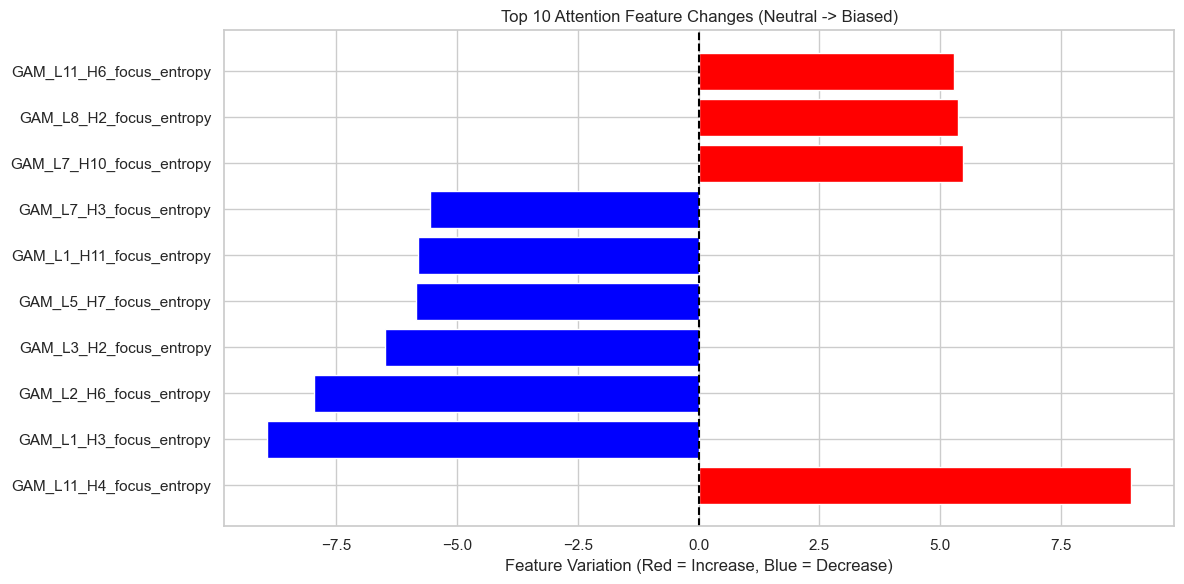

In [ ]:

print("EXAMPLE 2: NEUTRAL Sentence -> What would make it Biased?")

# Select a Neutral example from X_test (label=0) that was correctly classified (pred=0)
neutral_indices = X_test.index[(y_test == 0) & (final_model.predict(X_test) == 0)]

if len(neutral_indices) > 0:
    # Pick the first available example
    idx_orig = neutral_indices[0]
    
    # Original Text and Vector
    text_orig = df_sentences.loc[idx_orig, 'text']
    vec_orig = X_test.loc[idx_orig].values
    
    print(f"\nOriginal Sentence (Classified as NEUTRAL):")
    print(f"   \"{text_orig}\"")
    
    # Find closest Counterfactual (Biased)
    cf_vec, cf_idx, dist = find_counterfactual(idx_orig, X_test, final_model)
    
    if cf_vec is not None:
        text_cf = df_sentences.loc[cf_idx, 'text']
        print(f"\nClosest Counterfactual (Classified as BIASED):")
        print(f"   \"{text_cf}\"")
        print(f"   (Distance in feature space: {dist:.4f})")
        
        # Visualize Feature Changes
        diff = cf_vec - vec_orig
        feat_names = X_test.columns
        
        # Get top 10 absolute changes
        top_ids = np.argsort(np.abs(diff))[::-1][:10]
        
        plot_feats = [feat_names[i] for i in top_ids]
        plot_vals = [diff[i] for i in top_ids]
        
        plt.figure(figsize=(12, 6))
        colors = ['red' if v > 0 else 'blue' for v in plot_vals]
        plt.barh(plot_feats, plot_vals, color=colors)
        plt.title(f"Top 10 Attention Feature Changes (Neutral -> Biased)")
        plt.xlabel("Feature Variation (Red = Increase, Blue = Decrease)")
        plt.axvline(0, color='black', linestyle='--')
        plt.tight_layout()
        plt.show()
    else:
        print("No biased counterfactual found in this dataset.")
else:
    print("No correctly classified neutral examples found in X_test to analyze.")

=== SHAP Global Importance (Modo Ultra-Seguro) ===
Tentando TreeExplainer (Rápido)...
TreeExplainer falhou (could not convert string to float: '[5E-1]'). Fallback para KernelExplainer...
Calculando SHAP (Kernel) com nsamples=100...


  0%|          | 0/12 [00:00<?, ?it/s]

c:\Users\anoca\Documents\GitHub\attention-atlas\inspectus-env\Lib\site-packages\sklearn\linear_model\_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=1.920e-01, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\anoca\Documents\GitHub\attention-atlas\inspectus-env\Lib\site-packages\shap\explainers\_kernel.py:708: UserWarning: Linear regression equation is singular, a least squares solutions is used instead.
To avoid this situation and get a regular matrix do one of the following:
1) turn up the number of samples,
2) turn up the L1 regularization with num_features(N) where N is less than the number of samples,
3) group features together to reduce the number of inputs that need to be explained.
  warnings.warn(
c:\Users\anoca\Documents\GitHub\attention-atlas\inspectus-env\Lib\site-packages\sklearn

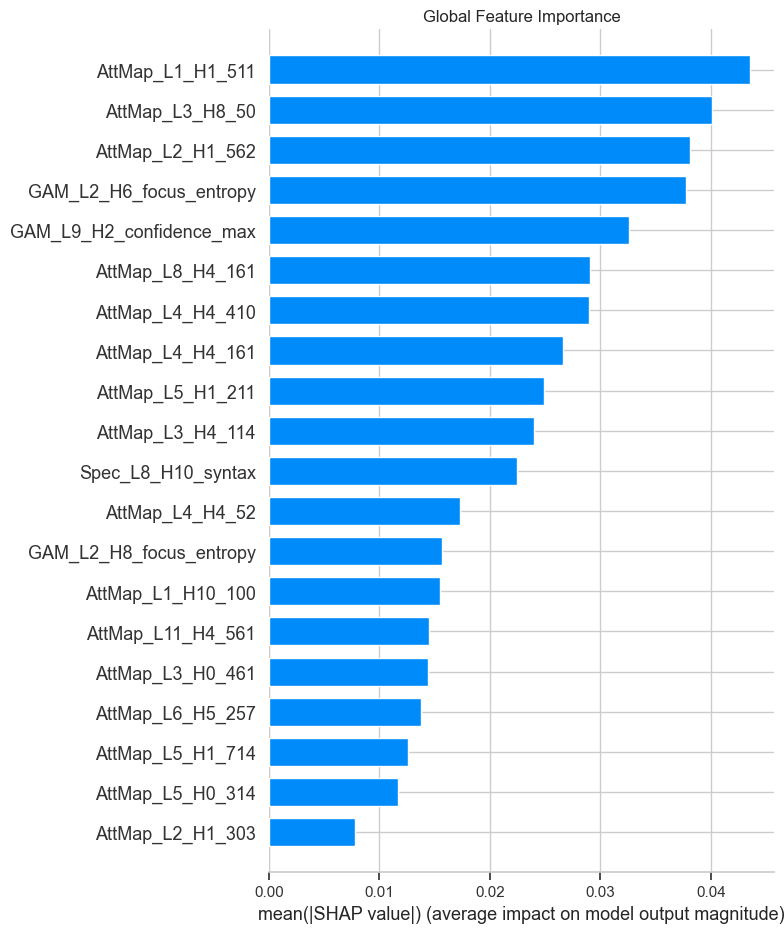

In [ ]:
import shap
import gc
import numpy as np

print("=== SHAP Global Importance (Modo Ultra-Seguro) ===")

# Limpa memória antes de começar
gc.collect()

# Recupera modelo e scaler do pipeline
model_step = final_model.named_steps['m']
scaler_step = final_model.named_steps['s']

# Escalar dados de teste
X_test_scaled = scaler_step.transform(X_test)
X_test_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# 1. Reduz drasticamente o número de amostras para o cálculo (apenas 5)
X_shap = X_test_df.sample(12, random_state=42)

try:
    print("Tentando TreeExplainer (Rápido)...")
    explainer = shap.TreeExplainer(model_step)
    shap_values = explainer.shap_values(X_shap)
    if isinstance(shap_values, list): shap_values = shap_values[1]

except Exception as e:
    print(f"TreeExplainer falhou ({e}). Fallback para KernelExplainer...")
    
    # 2. Usa a MEDIANA do treino como background (apenas 1 linha) para economizar memória
    background = np.median(scaler_step.transform(X_train), axis=0).reshape(1, -1)
    
    f = lambda x: model_step.predict_proba(x)[:, 1]
    explainer = shap.KernelExplainer(f, background)
    
    # 3. CRÍTICO: Limita nsamples=100. 
    # O padrão ("auto") tenta milhares de combinações, o que causou o erro de 40GB.
    print("Calculando SHAP (Kernel) com nsamples=100...")
    shap_values = explainer.shap_values(X_shap, nsamples=100)

# Plot Results
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_shap, plot_type="bar", show=False)
plt.title("Global Feature Importance")
plt.tight_layout()
plt.show()

## Live Prediction

In [ ]:
def predict_new_sentence(sentence):
    print(f"Processing: \"{sentence}\"...")
    
    # 1. Feature Extraction (BERT Attention)
    # Uses the 'manager' already loaded at the start of the notebook
    feats = extract_features_for_sentence(sentence, "bert-base-uncased", manager)
    
    # 2. Prepare DataFrame
    df_input = pd.DataFrame([feats])
    
    # 3. Align Columns with Training Data (X_final)
    # The model expects exactly the same columns selected by VarianceThreshold
    cols_expected = X_final.columns
    
    # Initialize empty dataframe with correct columns
    df_aligned = pd.DataFrame(0.0, index=[0], columns=cols_expected)
    
    # Fill matching columns
    common_cols = [c for c in cols_expected if c in df_input.columns]
    df_aligned[common_cols] = df_input[common_cols]
    
    # 4. Predict using the Final Pipeline
    prob_bias = final_model.predict_proba(df_aligned)[0, 1]
    prediction = final_model.predict(df_aligned)[0]
    
    label = "BIASED" if prediction == 1 else "NEUTRAL"
    
    print("-" * 30)
    print(f"Result: {label}")
    print(f"Confidence (Bias Probability): {prob_bias:.2%}")
    print("-" * 30)

# Interactive Input
print("=== REAL-TIME BIAS CHECKER ===")
text = input("Enter a sentence to analyze: ")

if text and text.strip():
    predict_new_sentence(text)
else:
    print("No text entered. Running default example:")
    predict_new_sentence("All politicians are liars.")

=== REAL-TIME BIAS CHECKER ===
Processing: "that woman is nice"...
------------------------------
Result: BIASED
Confidence (Bias Probability): 95.64%
------------------------------
